<a href="https://colab.research.google.com/github/WenyiYao/Augmented-Audio-Feature-Extraction/blob/main/augmented_audio_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install resampy six

In [2]:
import numpy as np
import tensorflow as tf

# Implementation of SpecAugment: A Simple Data Augmentation Method for Automatic Speech Recognition
# Ref: https://arxiv.org/pdf/1904.08779.pdf
# Ref: https://github.com/DemisEom/SpecAugment/blob/master/SpecAugment/spec_augment_tensorflow.py

import tensorflow as tf
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np


class SpecAugment():
    '''
    Augmentation Parameters for policies
    -----------------------------------------
    Policy | W  | F  | m_F |  T  |  p  | m_T
    -----------------------------------------
    None   |  0 |  0 |  -  |  0  |  -  |  -
    -----------------------------------------
    LB     | 80 | 27 |  1  | 100 | 1.0 | 1
    -----------------------------------------
    LD     | 80 | 27 |  2  | 100 | 1.0 | 2
    -----------------------------------------
    SM     | 40 | 15 |  2  |  70 | 0.2 | 2
    -----------------------------------------
    SS     | 40 | 27 |  2  |  70 | 0.2 | 2
    -----------------------------------------

    LB  : LibriSpeech basic
    LD  : LibriSpeech double
    SM  : Switchboard mild
    SS  : Switchboard strong
    W   : Time Warp parameter
    F   : Frequency Mask parameter
    m_F : Number of Frequency masks
    T   : Time Mask parameter
    p   : Parameter for calculating upper bound for time mask
    m_T : Number of time masks
    '''

    def __init__(self, frequency_mask_param=27, frequency_masks=1, time_masking_para=15, time_masks=1):
        self.frequency_mask_param = frequency_mask_param
        self.frequency_masks = frequency_masks
        self.time_masking_para = time_masking_para
        self.time_masks = time_masks

    def frequency_mask(self, mel_spectrogram):
        num_mel_channels = tf.shape(mel_spectrogram)[1]  # 'n_mels' is along the second axis

        for _ in range(self.frequency_masks):
            f = tf.random.uniform([], minval=0, maxval=self.frequency_mask_param, dtype=tf.int32)
            f0 = tf.random.uniform([], minval=0, maxval=num_mel_channels - f, dtype=tf.int32)

            # Creating a 1D mask that can be broadcast
            mask = tf.concat([
                tf.ones((f0,)),
                tf.zeros((f,)),
                tf.ones((num_mel_channels - f0 - f,))
            ], axis=0)

            # Reshape mask to be broadcastable with the spectrogram shape
            mask = tf.reshape(mask, [1, num_mel_channels, 1, 1])

            mel_spectrogram *= mask

        return mel_spectrogram


    import tensorflow as tf

    def time_mask(self, mel_spectrogram):
        num_time_steps = tf.shape(mel_spectrogram)[2]  # time is along the third axis

        if num_time_steps <= self.time_masking_para:
            self.time_masking_para = num_time_steps // 5  # Adjust t to be 1/5 the time steps if too large

        for _ in range(self.time_masks):
            t = tf.random.uniform([], minval=0, maxval=self.time_masking_para, dtype=tf.int32)
            t0 = tf.random.uniform([], minval=0, maxval=num_time_steps - t, dtype=tf.int32)

            # Create a mask with ones, then zeros, and ones again
            mask = tf.concat([
                tf.ones((1, 1, t0, 1)),  # Ones before the mask
                tf.zeros((1, 1, t, 1)),  # Zeros during the mask
                tf.ones((1, 1, num_time_steps - t0 - t, 1))  # Ones after the mask
            ], axis=2)  # Concatenate along the time axis

            # Apply the mask to the spectrogram
            mel_spectrogram *= mask

        return mel_spectrogram

    def apply(self, mel_spectrogram):
        """Apply SpecAugment."""
        tau = mel_spectrogram.shape[1]
        shape = mel_spectrogram.shape
        mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1], 1))

        mel_spectrogram = self.frequency_mask(mel_spectrogram)
        mel_spectrogram = self.time_mask(mel_spectrogram)
        return np.reshape(mel_spectrogram, shape)

    def mixup(self, spectrogram1, spectrogram2, alpha=0.2):
        mix_lambda = np.random.beta(alpha, alpha)
        mixed_spectrogram = mix_lambda * spectrogram1 + (1 - mix_lambda) * spectrogram2
        return mixed_spectrogram, mix_lambda


In [3]:
import tensorflow as tf
import random
import numpy as np

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, labels, batch_size, spec_augmenter, mixup_alpha=0.2, sr=22050, n_fft=1024, hop_length=512, n_mels=128, segment_length=64, overlap=0.5):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.spec_augmenter = spec_augmenter
        self.mixup_alpha = mixup_alpha
        self.sr = sr
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.segment_length = segment_length
        self.overlap = overlap

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]

        augmented_data = []
        augmented_labels = []

        for i, file_path in enumerate(batch_files):
            log_mel_spectrogram = log_mel(file_path, sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)

            # Perform Mixup with a certain probability
            if random.random() < 0.5 and len(batch_files) > 1:
                j = random.randint(0, len(batch_files) - 1)
                log_mel_spectrogram2 = log_mel(batch_files[j], sr=self.sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)
                mixed_spectrogram, mix_lambda = self.spec_augmenter.mixup(log_mel_spectrogram, log_mel_spectrogram2, self.mixup_alpha)
                label = mix_lambda * batch_labels[i] + (1 - mix_lambda) * batch_labels[j]
            else:
                mixed_spectrogram = log_mel_spectrogram
                label = batch_labels[i]

            # Apply SpecAugment
            augmented_spectrogram = self.spec_augmenter.apply(mixed_spectrogram)
            segments = segment_log_mel_spectrogram(augmented_spectrogram, segment_length=self.segment_length, overlap=self.overlap)

            augmented_data.extend(segments)
            augmented_labels.extend([label] * len(segments))

        return np.array(augmented_data)[..., np.newaxis], np.array(augmented_labels)


In [4]:
import os

def process_dataset(fold_dir):
  features = []
  labels = []

  files = [f for f in os.listdir(fold_dir)]
  for file_name in files:
    file_path = os.path.join(fold_dir, file_name)
    segments = log_mel(file_path)
    features.extend(segments)
    label = file_name.split('-')[1]
    labels.extend([label] * len(segments))

    return np.array(features), np.array(labels)


In [5]:
def log_mel(file_path, sr=22050, n_fft=1024, hop_length=512, n_mels=128, segment_length=64, overlap=0.5):
    # Load the audio file, ensuring it's mono
    audio, _ = librosa.load(file_path, sr=sr, mono=True)

    # Perform STFT
    stft = librosa.stft(audio, n_fft=n_fft, hop_length=hop_length, window='hamming')

    # Calculate the amplitude spectrogram
    spectrogram = np.abs(stft)

    # Convert to Mel scale
    mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram**2, sr=sr, n_mels=n_mels)

    # Convert to logarithmic scale
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return log_mel_spectrogram

def segment_log_mel_spectrogram(log_mel_spectrogram, segment_length=64, overlap=0.5):
    hop_length = int(segment_length * (1 - overlap))
    num_segments = (log_mel_spectrogram.shape[1] - segment_length) // hop_length + 1
    segments = []

    for i in range(num_segments):
        start = i * hop_length
        end = start + segment_length
        segment = log_mel_spectrogram[:, start:end]
        if segment.shape[1] < segment_length:  # Zero-padding
            segment = np.pad(segment, ((0, 0), (0, segment_length - segment.shape[1])), mode='constant')
        segments.append(segment)

    return np.array(segments)

In [6]:
import numpy as np

# Create a small dataset
X_sample = np.random.rand(10, 128, 173, 1)  # 10 samples, 128 mel bins, 173 time frames, 1 channel
y_sample = np.random.randint(0, 10, size=(10,))  # 10 labels for 10 samples
y_sample = tf.keras.utils.to_categorical(y_sample, num_classes=10)  # One-hot encode labels

# Instantiate SpecAugment
spec_augmenter = SpecAugment()

# Instantiate DataGenerator
data_generator = DataGenerator(X_sample, y_sample, batch_size=2, spec_augmenter=spec_augmenter)


X_batch shape: (8, 128, 64, 1)
y_batch shape: (8,)


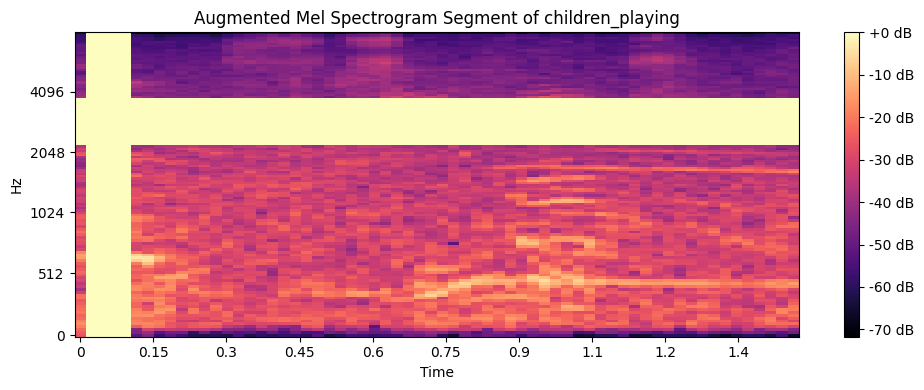

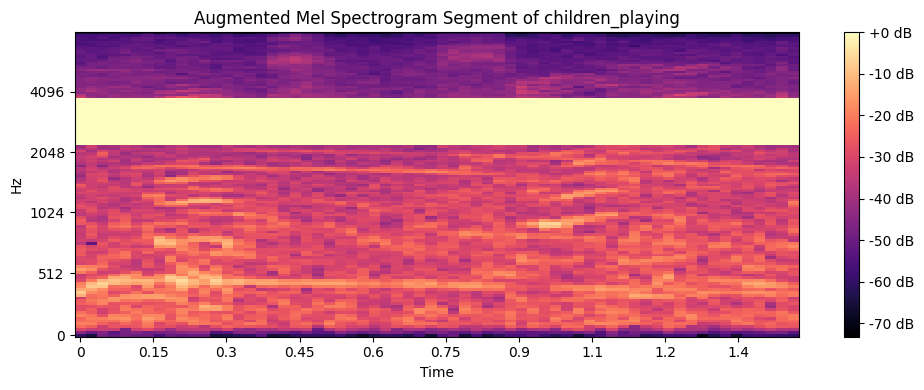

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa.display

# Example file paths and labels
file_paths = ['./drive/MyDrive/EVD/dataset/urbansound8k/audio/fold1/193698-2-0-140.wav', './drive/MyDrive/EVD/dataset/urbansound8k/audio/fold1/72261-3-0-17.wav']
labels = [2, 3]  # Example labels

# Instantiate SpecAugment
spec_augmenter = SpecAugment()

# Instantiate DataGenerator
data_generator = DataGenerator(file_paths, labels, batch_size=2, spec_augmenter=spec_augmenter)

# Retrieve the first batch
X_batch, y_batch = data_generator.__getitem__(0)

# Print shapes to check
print(f"X_batch shape: {X_batch.shape}")  # Expected shape: (number_of_segments, 128, 64, 1)
print(f"y_batch shape: {y_batch.shape}")  # Expected shape: (number_of_segments, )

# Plot the first spectrogram in the batch
plt.figure(figsize=(10, 4))
librosa.display.specshow(X_batch[0].squeeze(), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
# title with label
plt.title(f'Augmented Mel Spectrogram Segment of children_playing')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
librosa.display.specshow(X_batch[1].squeeze(), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Augmented Mel Spectrogram Segment of children_playing')
plt.tight_layout()
plt.show()


Based on the directions at: https://github.com/tensorflow/models/tree/master/research/audioset

Ref: https://colab.research.google.com/drive/1TbX92UL9sYWbdwdGE0rJ9owmezB-Rl1C#scrollTo=xEl3w-RjCPwp

In [8]:
!git clone https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [9]:
# Download data files into same directory as code.
!curl -O https://storage.googleapis.com/audioset/vggish_model.ckpt
!curl -O https://storage.googleapis.com/audioset/vggish_pca_params.npz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  277M  100  277M    0     0  28.1M      0  0:00:09  0:00:09 --:--:-- 31.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 73020  100 73020    0     0   136k      0 --:--:-- --:--:-- --:--:--  136k


In [10]:
!ls

drive		 requirements.txt	   vggish_input.py	  vggish_slim.py
mel_features.py  sample_data		   vggish_model.ckpt	  vggish_smoke_test.py
models		 vggish			   vggish_params.py	  vggish_train_demo.py
__pycache__	 vggish_export_tfhub.py    vggish_pca_params.npz
README.md	 vggish_inference_demo.py  vggish_postprocess.py


In [11]:
!ls models/research/audioset/vggish

mel_features.py  requirements.txt	   vggish_input.py	  vggish_slim.py
__pycache__	 vggish_export_tfhub.py    vggish_params.py	  vggish_smoke_test.py
README.md	 vggish_inference_demo.py  vggish_postprocess.py  vggish_train_demo.py


In [12]:
!cp -r models/research/audioset/vggish/* .

In [13]:
from vggish_smoke_test import *


Testing your install of VGGish

Resampling via resampy works!
Log Mel Spectrogram example:  [[-4.48313252 -4.27083405 -4.17064267 ... -4.60069383 -4.60098887
  -4.60116305]
 [-4.48313252 -4.27083405 -4.17064267 ... -4.60069383 -4.60098887
  -4.60116305]
 [-4.48313252 -4.27083405 -4.17064267 ... -4.60069383 -4.60098887
  -4.60116305]
 ...
 [-4.48313252 -4.27083405 -4.17064267 ... -4.60069383 -4.60098887
  -4.60116305]
 [-4.48313252 -4.27083405 -4.17064267 ... -4.60069383 -4.60098887
  -4.60116305]
 [-4.48313252 -4.27083405 -4.17064267 ... -4.60069383 -4.60098887
  -4.60116305]]


/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:318: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


VGGish embedding:  [-2.72986382e-01 -1.80314153e-01  5.19921184e-02 -1.43571526e-01
 -1.04673728e-01 -4.96598154e-01 -1.75267965e-01  4.23147976e-01
 -8.22126150e-01 -2.16801405e-01 -1.17509276e-01 -6.70077026e-01
  1.43174574e-01 -1.44183934e-01  8.73491913e-03 -8.71972442e-02
 -1.84393525e-01  5.96655607e-01 -3.43809605e-01 -5.79104424e-02
 -1.65071294e-01  4.22911644e-02 -2.55293399e-01 -2.36356765e-01
  1.80295616e-01  3.02612185e-01  1.08356833e-01 -4.48398024e-01
  1.22757629e-01 -2.99955189e-01 -5.55934191e-01  5.05966544e-01
  2.05210358e-01  8.87591839e-01  9.03702497e-01 -2.10566416e-01
 -3.27462405e-02  1.38691410e-01 -2.27416530e-01  1.14804000e-01
  5.95410109e-01 -4.76971269e-01  2.28232622e-01  1.54627025e-01
  1.64934218e-01  7.19252825e-01  1.24101830e+00  5.61996222e-01
  2.73531973e-01  3.09788287e-02  2.10977703e-01 -6.09551668e-01
 -3.15282375e-01  1.76392645e-01 -8.96190405e-02 -4.26822364e-01
  3.12993884e-01 -1.56592295e-01  3.31673503e-01  1.29436389e-01
  1.66

In [14]:
import vggish_input
import vggish_params
import vggish_postprocess
import vggish_slim

def extract_vggish_features(waveform, sr=22050):
    examples_batch = vggish_input.waveform_to_examples(waveform, sr)

    # Define the graph within the context
    with tf.Graph().as_default():
        vggish_slim.define_vggish_slim(training=False)

        with tf.compat.v1.Session() as sess:
            # Initialize variables
            sess.run(tf.compat.v1.global_variables_initializer())

            # Load the VGGish model checkpoint
            vggish_slim.load_vggish_slim_checkpoint(sess, 'vggish_model.ckpt')

            # Get the input and output tensors
            features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
            embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)

            # Run the model to get the embeddings
            [embedding_batch] = sess.run([embedding_tensor], feed_dict={features_tensor: examples_batch})

            # Load PCA parameters for postprocessing
            pca_params = 'vggish_pca_params.npz'
            postprocessor = vggish_postprocess.Postprocessor(pca_params)

            # Postprocess the embeddings
            postprocessed_batch = postprocessor.postprocess(embedding_batch)

            return postprocessed_batch


In [15]:
audio_path = './drive/MyDrive/EVD/dataset/urbansound8k/audio/fold1/193698-2-0-140.wav'
waveform, sr = librosa.load(audio_path, sr=22050, mono=True)
features = extract_vggish_features(waveform, sr)
print(features.shape)

(4, 128)


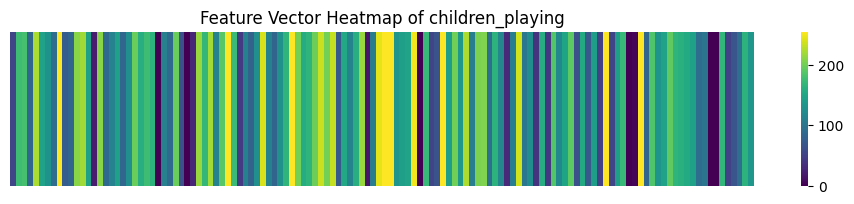

In [16]:
import seaborn as sns

# Visualize a single feature vector as a heatmap
plt.figure(figsize=(12, 2))
sns.heatmap(features[0].reshape(1, -1), cmap='viridis', cbar=True, xticklabels=False, yticklabels=False)
plt.title('Feature Vector Heatmap of children_playing')
plt.show()

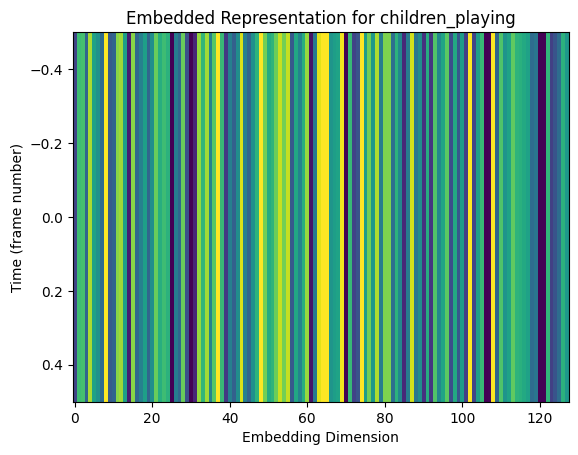

In [17]:
plt.imshow(features[0].reshape(1, -1),
           aspect='auto', cmap='viridis')
plt.xlabel('Embedding Dimension')
plt.ylabel('Time (frame number)')
plt.title('Embedded Representation for children_playing')
plt.grid(False);